# Investigation of condition number for approximation matricies

Copyright 2025 Stephan Kulla ("Kulla")

Licensed under the Apache License, Version 2.0 (the "Apache License") and Creative Commons Attribution 4.0 International (the "CC-BY License"). You may choose either of these licenses to govern your use of this project.

You may obtain a copy of the Apache License at:
    http://www.apache.org/licenses/LICENSE-2.0

You may obtain a copy of the CC-BY License at:
    https://creativecommons.org/licenses/by/4.0/

Unless required by applicable law or agreed to in writing, software and content distributed under the Apache License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the Apache License for the specific language governing permissions and limitations under the License.

Under the CC-BY License, you are free to share and adapt the material provided you give appropriate credit, provide a link to the license, and indicate if changes were made. See the CC-BY License for full details.

Third-Party Components and Licenses:
This product also includes third-party components which are distributed under their respective licenses. Please refer to the NOTICE file for details.

## Utility functions and imports

In [9]:
%load_ext jupyter_ai_magics

The jupyter_ai_magics extension is already loaded. To reload it, use:
  %reload_ext jupyter_ai_magics


In [10]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
%autoreload 2

In [12]:
import string
import sympy as sp

from IPython.display import display, Markdown

class LatexFormatter(string.Formatter):
    def format_field(self, value, format_spec):
        if format_spec == 'tex':
            return sp.printing.latex(value)
        if format_spec == '$' or format_spec == 'inline':
            return "$" + sp.printing.latex(value) + "$"
        elif format_spec == '$$' or format_spec == 'block':
            return "$$" + sp.printing.latex(value) + "$$"
        else:
            return super().format_field(value, format_spec)

def disp_md(template, **kwargs):
    display(Markdown(LatexFormatter().format(template, **kwargs)))

## Investigate the condition number of a matrix

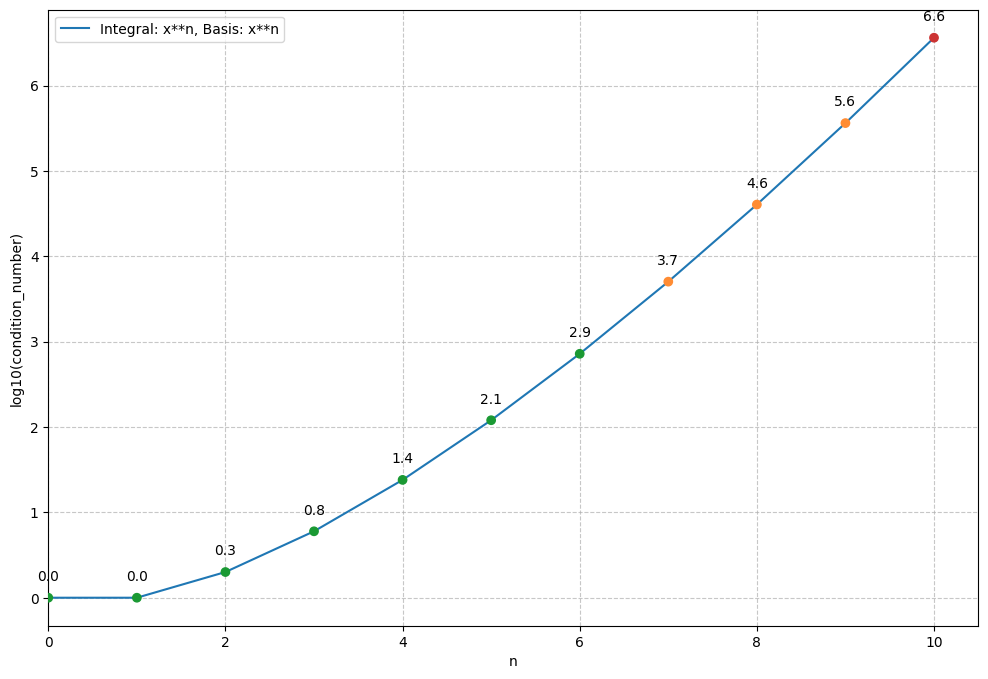

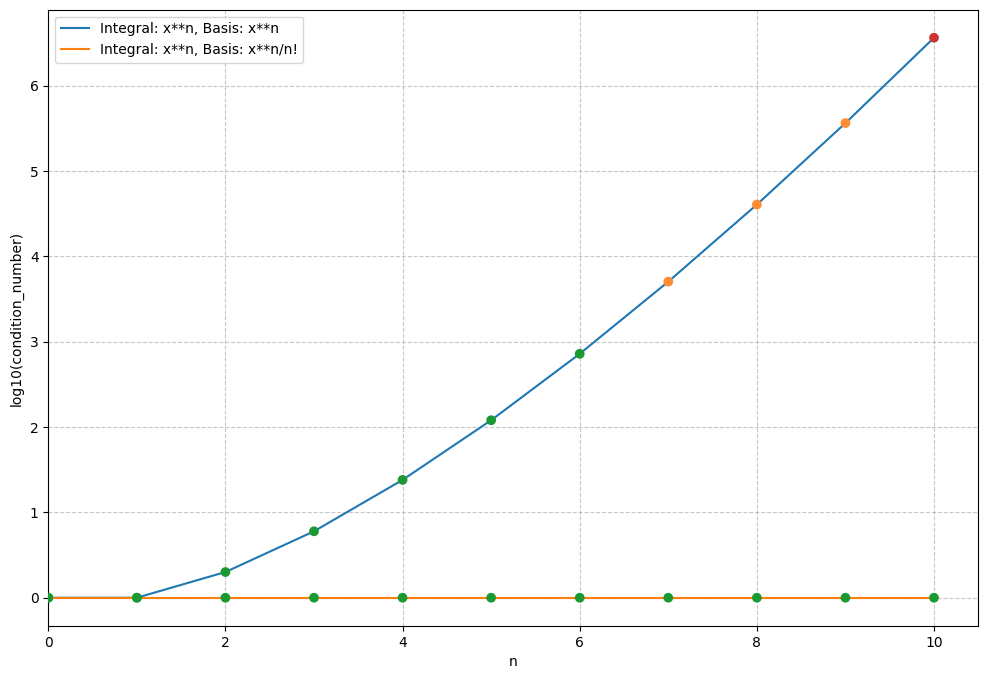

In [58]:
import matplotlib.pyplot as plt
import numpy as np

from functools import partial
from sympy.abc import x, n
from src.c_space import derivative_forms, integral_forms, vectors
from src.approximation import matrix_of

plt.rcParams["figure.figsize"] = [12,8]

green = (0.1, 0.6, 0.2)
orange = (1.0, 0.55, 0.2)
red = (0.8, 0.2, 0.2)

def condition_number(sp_matrix, p=2):
    np_matrix = np.array(sp_matrix).astype(np.float64)

    return np.log10(np.linalg.cond(np_matrix, p=p))

def investigate_condition_number(plots, p=2, max_number=10):
    for linear_forms, vectors, title in plots:
        def get_condition_number(n):
            return condition_number(matrix_of(linear_forms(n), vectors(n)), p=p)
    
        def get_color(condition_number_log10):
            if condition_number_log10 < 3:
                return green
            elif condition_number_log10 < 6:
                return orange
            else:
                return red
        
        ns = range(max_number+1)
        condition_numbers = [get_condition_number(n) for n in ns]
        colors = [get_color(value) for value in condition_numbers]

        plt.scatter(ns, condition_numbers, c=colors, zorder=5)
        plt.plot(ns, condition_numbers, "-", label=title)

        if len(plots) < 2:
            for i, value in enumerate(condition_numbers):
                plt.text(ns[i], value + 0.2, f'{value:.1f}', ha='center', zorder=6)

    plt.xlim((0, max_number+0.5))
    plt.xlabel("n")
    plt.ylabel("log10(condition_number)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.show()

investigate_condition_number([ (derivative_forms, partial(vectors, x**n), "Integral: x**n, Basis: x**n") ])
investigate_condition_number([
    (derivative_forms, partial(vectors, x**n), "Integral: x**n, Basis: x**n"),
    (derivative_forms, partial(vectors, x**n/sp.factorial(n)), "Integral: x**n, Basis: x**n/n!"),
])

In [60]:
import ipywidgets as widgets

dict_linear_forms = {
    "None": None,
    "Derivatives": derivative_forms,
    "Integral: x**n": partial(integral_forms, x**n, a=-1, b=1),
    "Integral: x**n/n!": partial(integral_forms, x**n/sp.factorial(n), a=-1, b=1),
    "Integral: (1-x)**n": partial(integral_forms, (1-x)**n, a=-1, b=1),
    "Integral: 1/n! (1-x)**n": partial(integral_forms, sp.S(1)/sp.factorial(n)*(1-x)**n, a=-1, b=1),
    "Integral: Legendre": partial(integral_forms, sp.legendre(n, x), a=-1, b=1),
    "Integral: Normed Legendre": partial(integral_forms, sp.legendre(n, x)*sp.sqrt((2*n+1)/2), a=-1, b=1)
}

dict_vectors = {
    "None": None,
    "Basis: x**n": x**n,
    "Basis: x**n/n!": x**n/sp.factorial(n),
    "Basis: 1/n! (1-x)**n": sp.S(1)/sp.factorial(n)*(1-x)**n,
    "Basis: (1-x)**n": (1-x)**n,
    "Basis: Legendre": sp.legendre(n, x),
    "Basis: Normed Legendre": sp.legendre(n, x)*sp.sqrt((2*n+1)/2)
}

p_values = [None, 2, 1, "fro", "inf"]

def dropdown(obj, description):
    return widgets.Dropdown(options=obj.keys() if isinstance(obj, dict) else obj, description=description)

dropdown_linear_forms = widgets.Dropdown(options=dict_linear_forms.keys(), description="Linear form:")
dropdown_vectors = widgets.Dropdown(options=dict_vectors.keys(), description="Vector basis:")
dropdown_p_value = widgets.Dropdown(options=p_values, description="p:")

def show_diagram(f1_lf, f1_v, f2_lf, f2_v, f3_lf, f3_v, f4_lf, f4_v, f5_lf, f5_v, f6_lf, f6_v, p):
    args = [(f1_lf, f1_v), (f2_lf, f2_v), (f3_lf, f3_v), (f4_lf, f4_v), (f5_lf, f5_v), (f6_lf, f6_v)]

    def get_plot(linear_forms_key, vectors_key):
        return (
            dict_linear_forms[linear_forms_key],
            partial(vectors, dict_vectors[vectors_key]),
            f"{linear_forms_key}, {vectors_key}"
        )

    plots = [get_plot(lf, v) for lf, v in args if lf != "None" and v != "None"]

    if len(plots) > 0:
        investigate_condition_number(plots, p=p, max_number=6)

widgets.interact_manual(
    show_diagram,
    f1_lf = dropdown(dict_linear_forms, "f1 LinForm:"),
    f2_lf = dropdown(dict_linear_forms, "f2 LinForm:"),
    f3_lf = dropdown(dict_linear_forms, "f3 LinForm:"),
    f4_lf = dropdown(dict_linear_forms, "f4 LinForm:"),
    f5_lf = dropdown(dict_linear_forms, "f5 LinForm:"),
    f6_lf = dropdown(dict_linear_forms, "f6 LinForm:"),
    f1_v = dropdown(dict_vectors, "f1 Basis:"),
    f2_v = dropdown(dict_vectors, "f2 Basis:"),
    f3_v = dropdown(dict_vectors, "f3 Basis:"),
    f4_v = dropdown(dict_vectors, "f4 Basis:"),
    f5_v = dropdown(dict_vectors, "f5 Basis:"),
    f6_v = dropdown(dict_vectors, "f6 Basis:"),
    p=dropdown(p_values, "p:")
)

interactive(children=(Dropdown(description='f1 LinForm:', options=('None', 'Derivatives', 'Integral: x**n', 'I…

<function __main__.show_diagram(f1_lf, f1_v, f2_lf, f2_v, f3_lf, f3_v, f4_lf, f4_v, f5_lf, f5_v, f6_lf, f6_v, p)>